In [114]:
from colorcloud.braga2024datasetname import InfUFGDataset
from torch import nn
from pathlib import Path
import numpy as np

from colorcloud.behley2019iccv import SphericalProjection, ProjectionTransform, UnfoldingProjection, ProjectionVizTransform
from matplotlib import pyplot as plt
from torchvision.transforms import v2

In [2]:
data_path = '/workspace/data'
ds = InfUFGDataset(data_path)
len(ds)

9382

Os valores parecem bons, mexer neles deixa as imagens estranhas, mas não consegui encaixar com os asserts.

In [3]:
class ProjectionVizModifiedTransform(nn.Module):
    "Pytorch transform to preprocess projection images for proper visualization."
    def __init__(self, color_map_rgb_np, learning_map_inv_np):
        super().__init__()
        self.color_map_rgb_np = color_map_rgb_np
        self.learning_map_inv_np = learning_map_inv_np
    
    def scale(self, img, min_value, max_value):
        # assert img.max() <= max_value
        # assert img.min() >= min_value
        # assert max_value > min_value
        
        img = img.clip(min_value, max_value)
        return (255.*(img - min_value)/(max_value - min_value)).astype(int)
    
    def forward(self, frame_img, label_img, mask_img):
        normalized_frame_img = None
        if frame_img is not None:
            x = self.scale(frame_img[:,:,0], -100., 100.)
            y = self.scale(frame_img[:,:,1], -100., 100.)
            z = self.scale(frame_img[:,:,2], -31., 5.)
            r = self.scale(frame_img[:,:,3], 0., 1.)
            d = self.scale(frame_img[:,:,4], 0., 100.)
            normalized_frame_img = np.stack((x, y, z, r, d), axis=-1)
            normalized_frame_img[mask_img == False] *= 0

        colored_label_img = None
        if label_img is not None:
            label_img[mask_img] = self.learning_map_inv_np[label_img[mask_img]]
            colored_label_img = np.zeros(label_img.shape + (3,))
            colored_label_img[mask_img] = self.color_map_rgb_np[label_img[mask_img]]
            colored_label_img = colored_label_img.astype(int)
        
        return normalized_frame_img, colored_label_img, mask_img

In [119]:
proj = SphericalProjection(fov_up_deg=16., fov_down_deg=-16., W=1800, H=16)
tfms = v2.Compose([
    ProjectionTransform(proj),
    ProjectionVizModifiedTransform(color_map_rgb_np=None, learning_map_inv_np=None),
])
ds.set_transform(tfms)

### Projeção Padrão

In [229]:
def plot_projections(img):
    fig, axs = plt.subplots(5, 1, figsize=(20,10), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,:,i])
        ax.set_title(title)
        ax.axis('off')

def plot_slices(img, start, end):
    fig, axs = plt.subplots(5, 1, figsize=(5,7), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,start:end,i])
        ax.set_title(title)
        ax.axis('off')

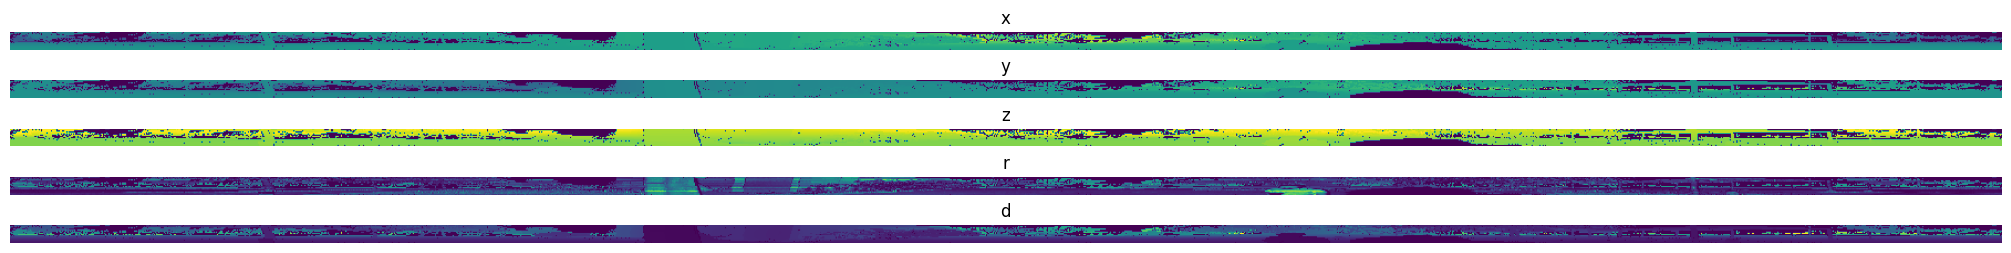

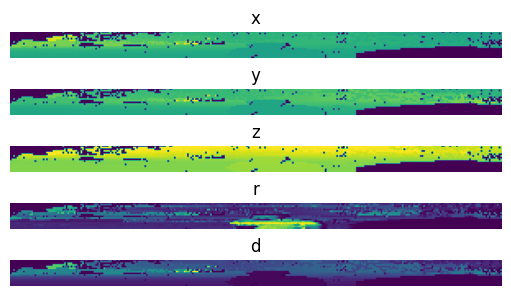

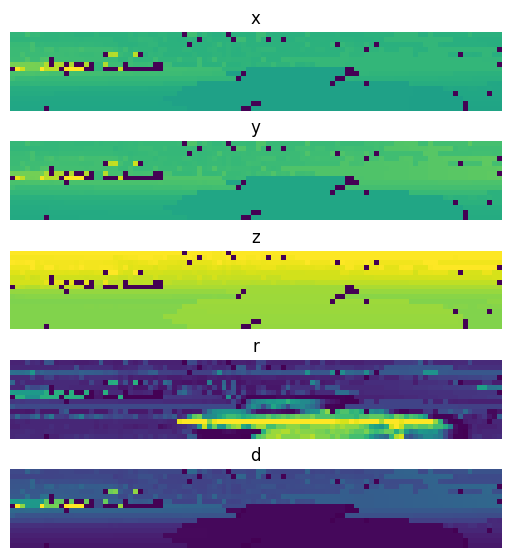

In [225]:
img, _, _ = ds[2012]
plot_projections(img)
plot_slices(img, start=1000, end=1300)
plot_slices(img, start=1100, end=1200)

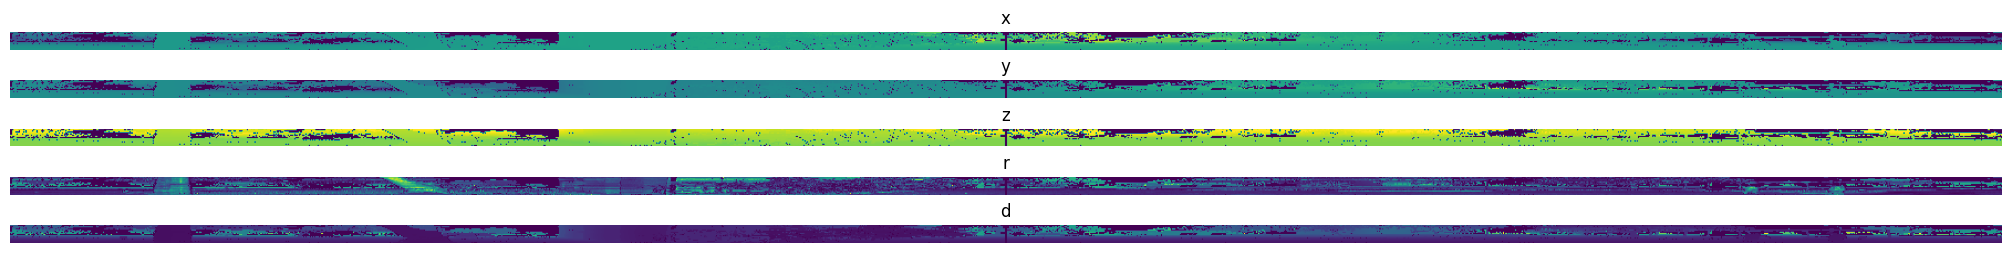

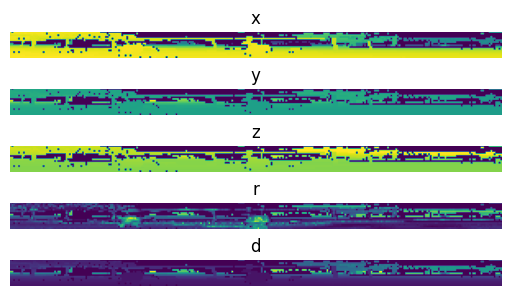

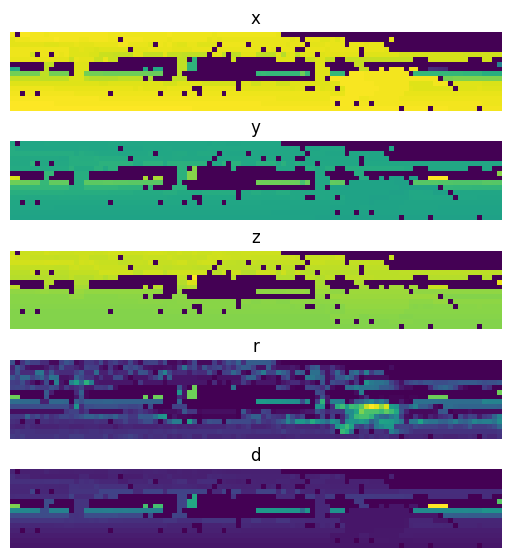

In [233]:
img, _, _ = ds[2004]
plot_projections(img)
plot_slices(img, start=1500, end=1800)
plot_slices(img, start=1500, end=1600)

### Projeção Modificada

In [234]:
def plot_projections(img):
    fig, axs = plt.subplots(5, 1, figsize=(20,7), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,:,i], aspect="auto")
        ax.set_title(title)
        ax.axis('off')


def plot_slices(img, start, end):
    fig, axs = plt.subplots(5, 1, figsize=(5,7), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,start:end,i], aspect="auto")
        ax.set_title(title)
        ax.axis('off')

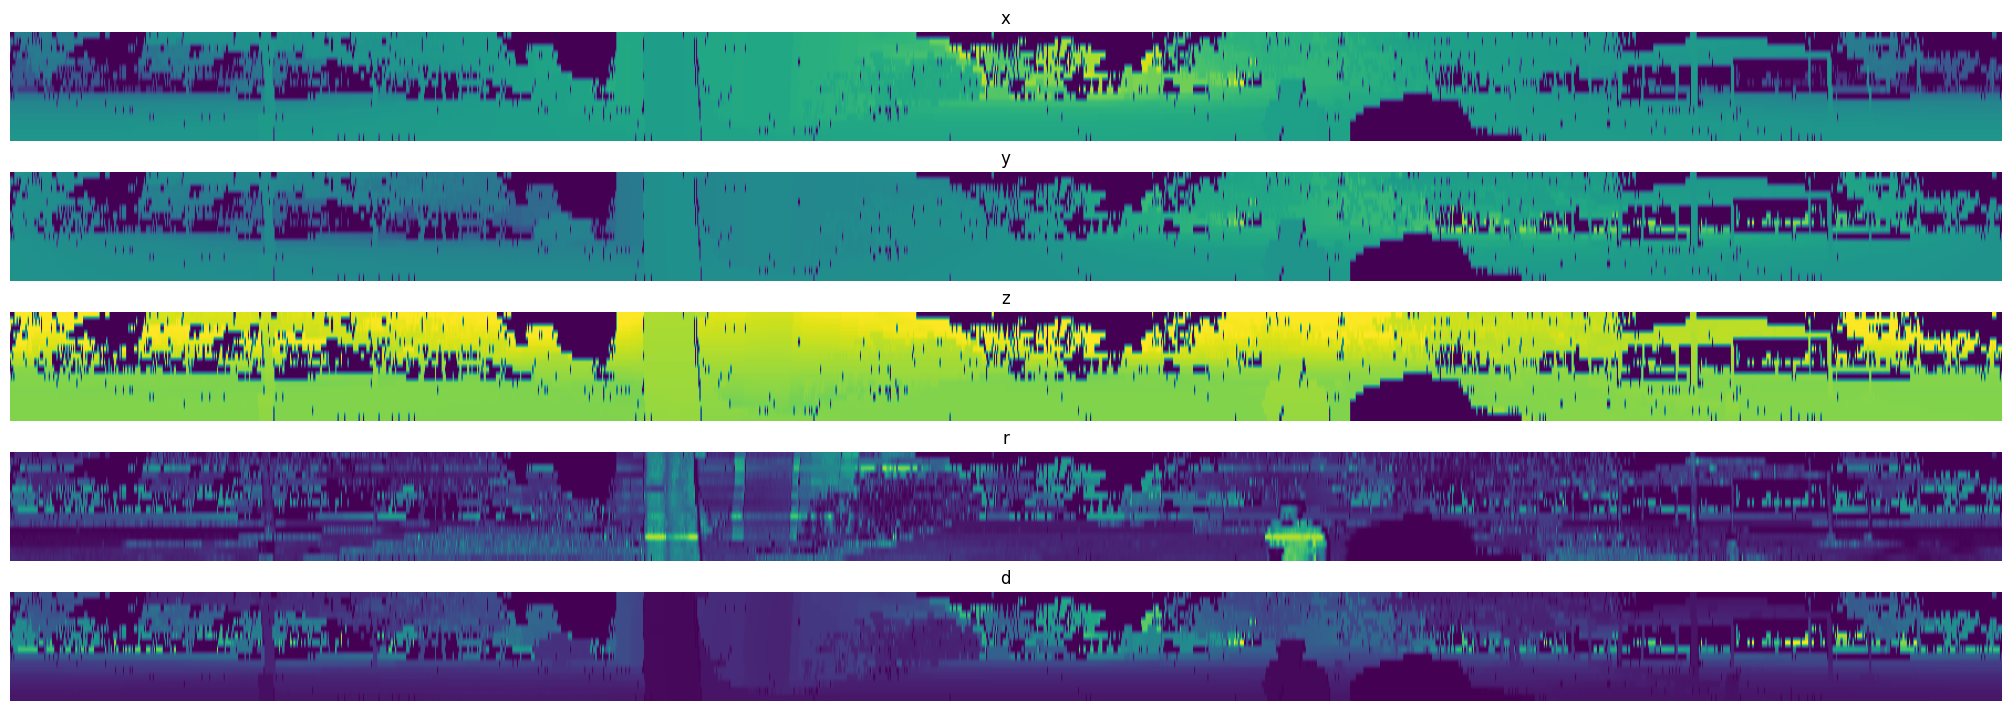

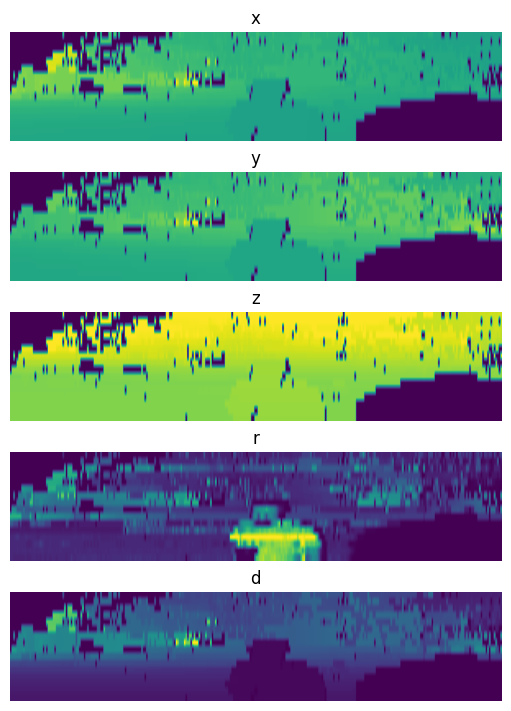

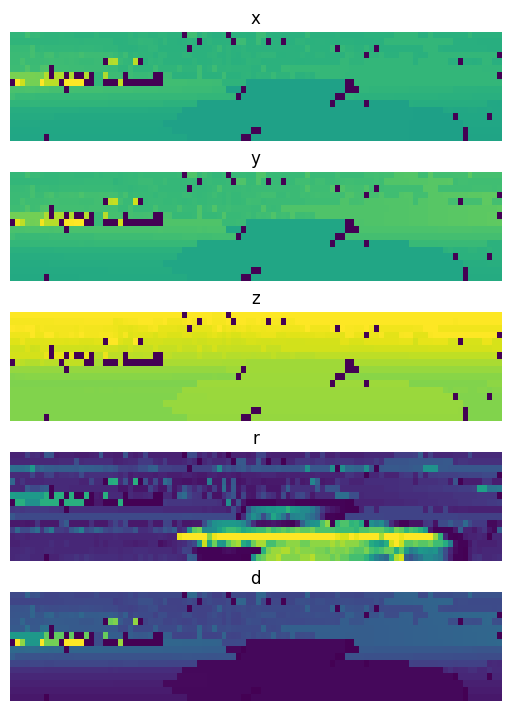

In [227]:
img, _, _ = ds[2012]
plot_projections(img)
plot_slices(img, start=1000, end=1300)
plot_slices(img, start=1100, end=1200)

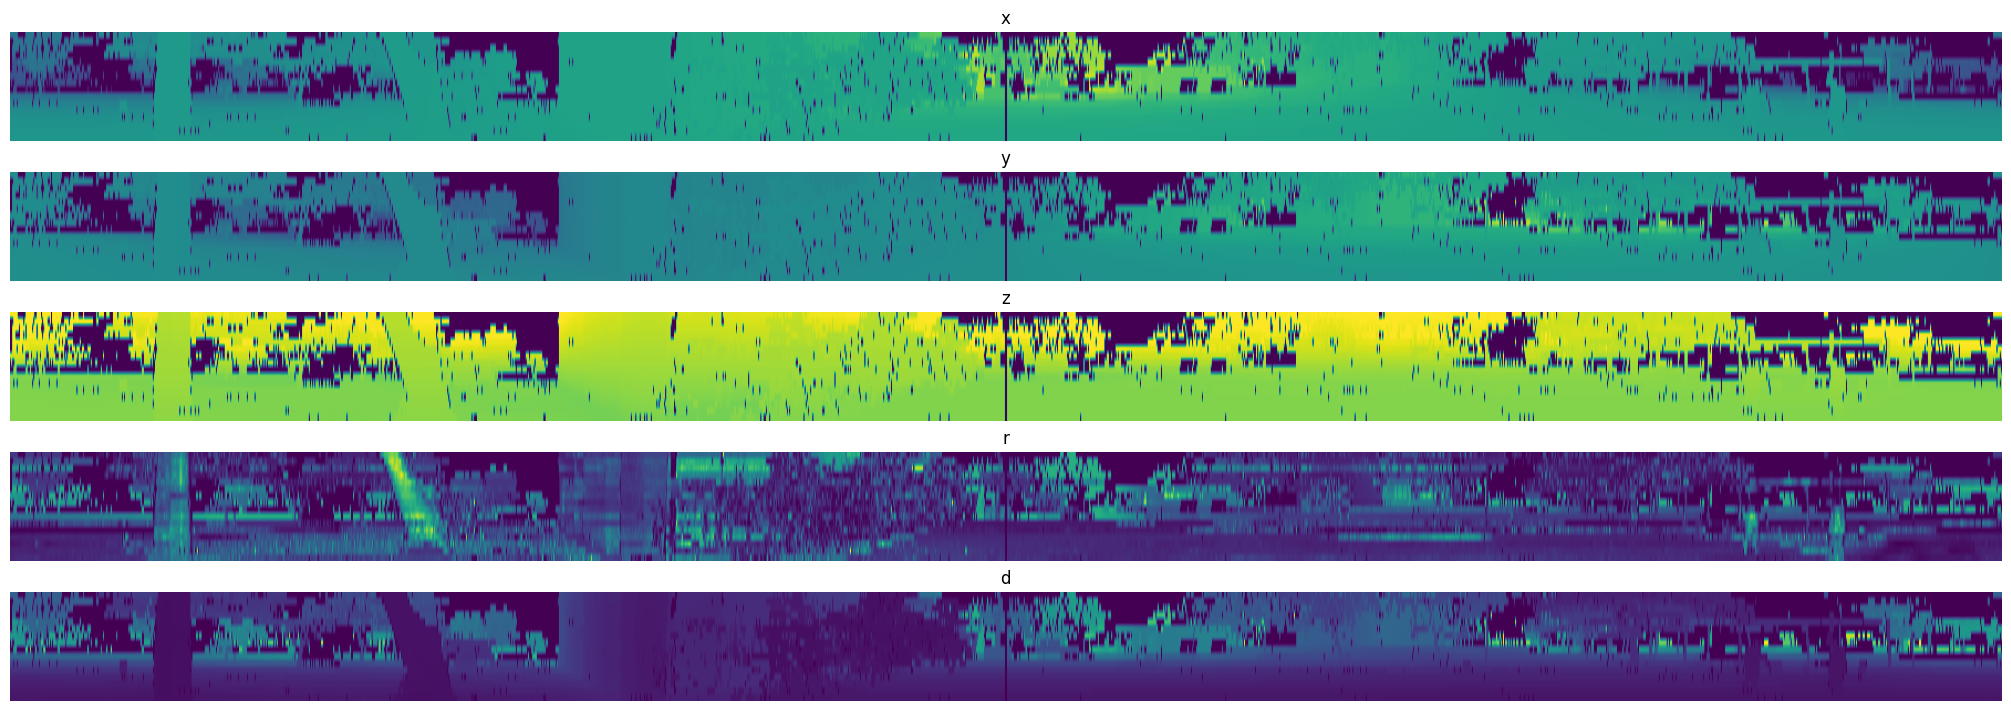

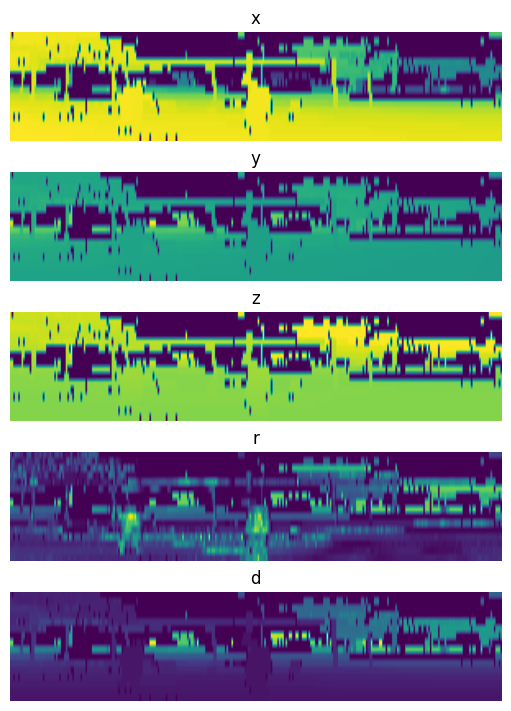

In [237]:
img, _, _ = ds[2004]
plot_projections(img)
plot_slices(img, start=1500, end=1800)

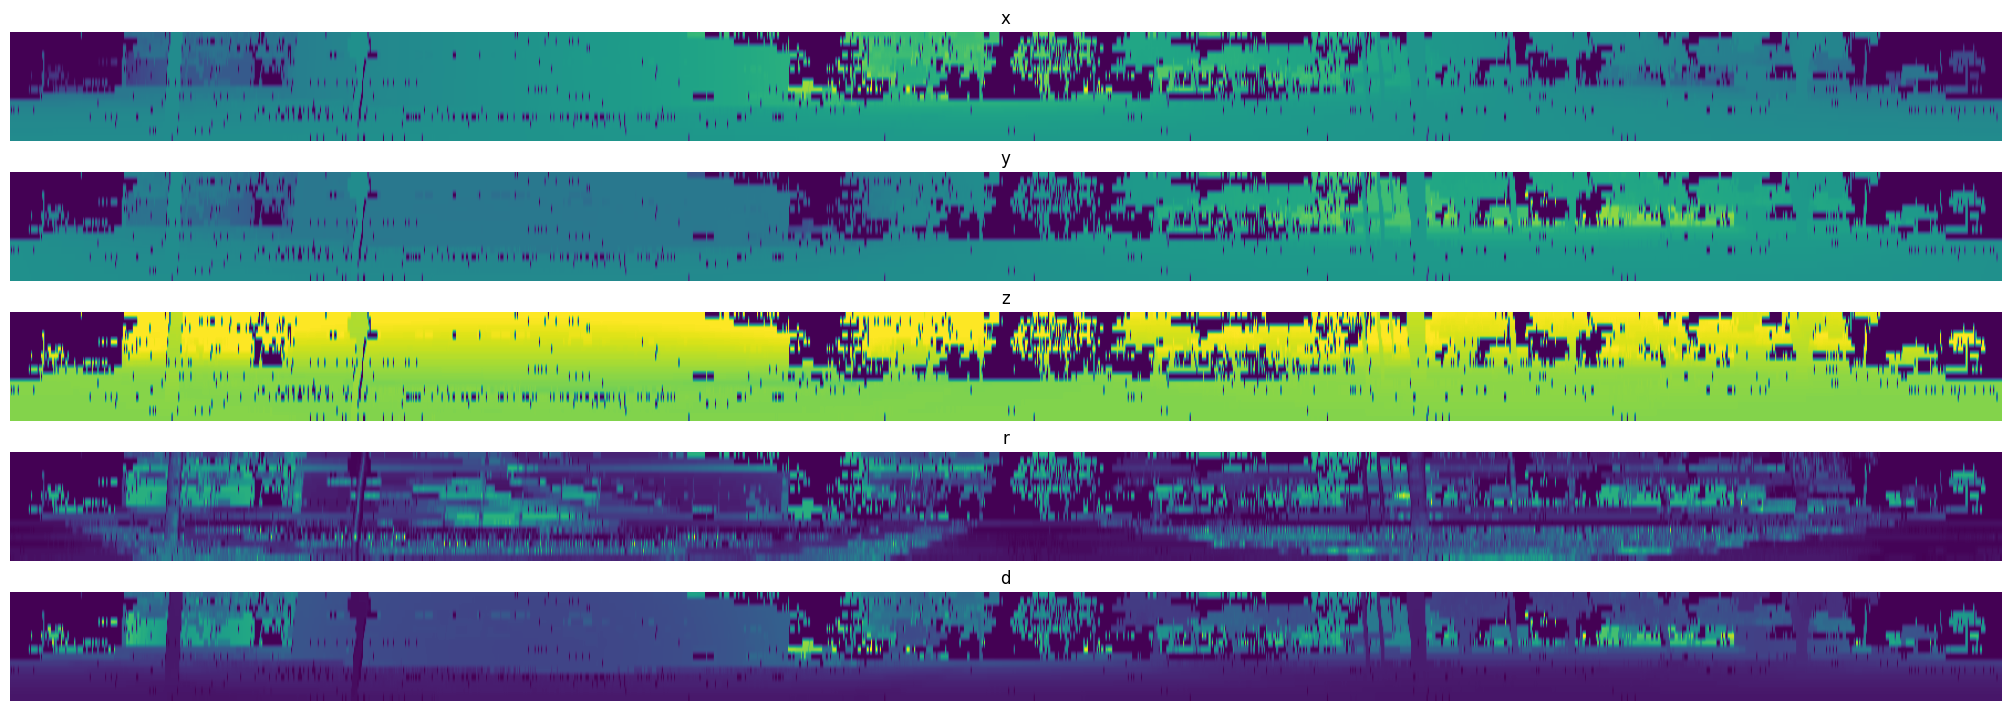

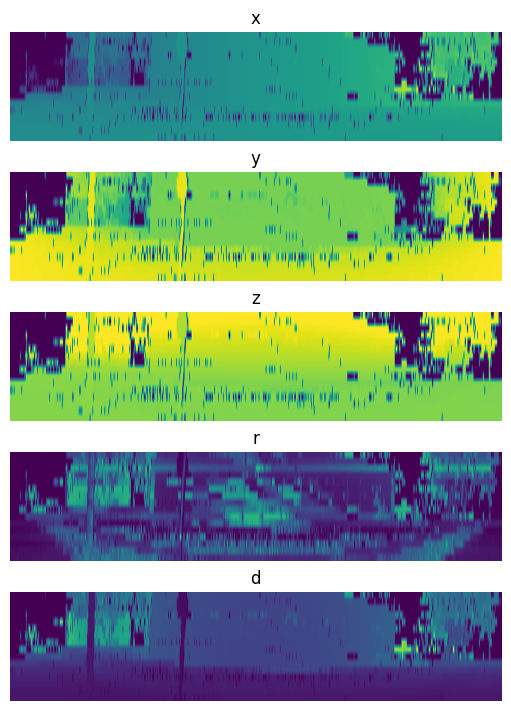

In [240]:
img, _, _ = ds[2033]
plot_projections(img)
plot_slices(img, start=0, end=900)

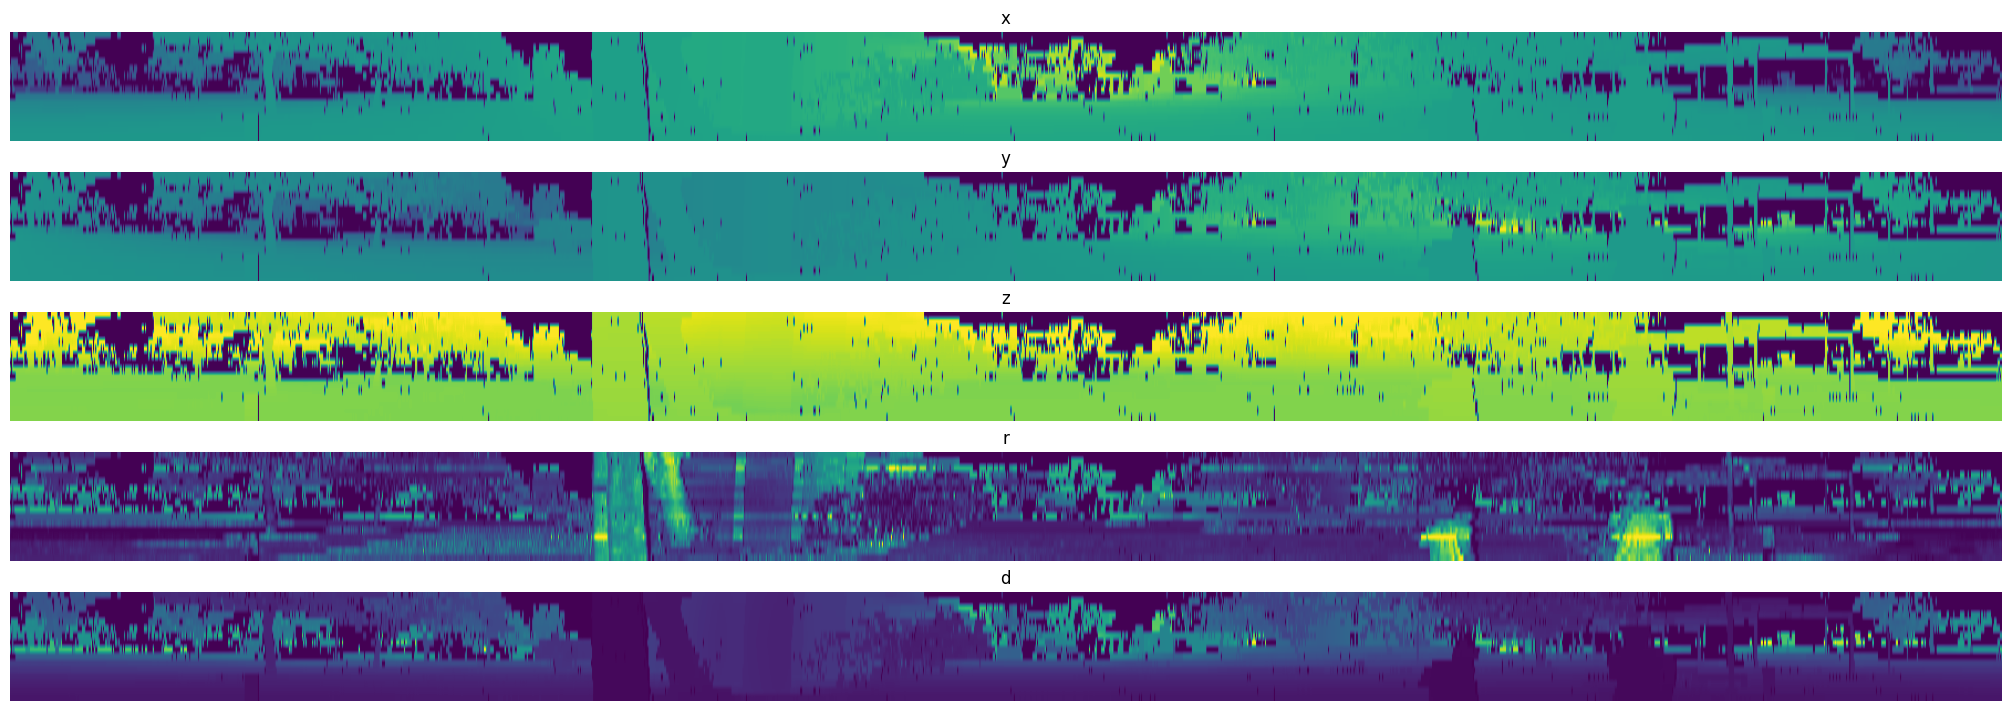

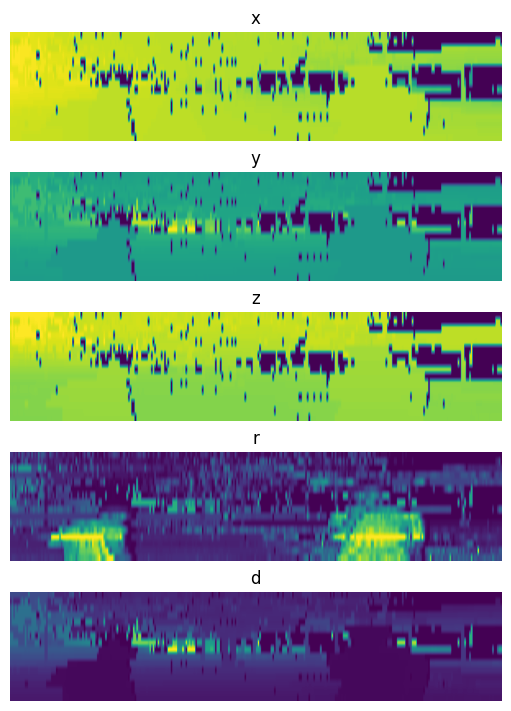

In [243]:
img, _, _ = ds[2071]
plot_projections(img)
plot_slices(img, start=1250, end=1550)

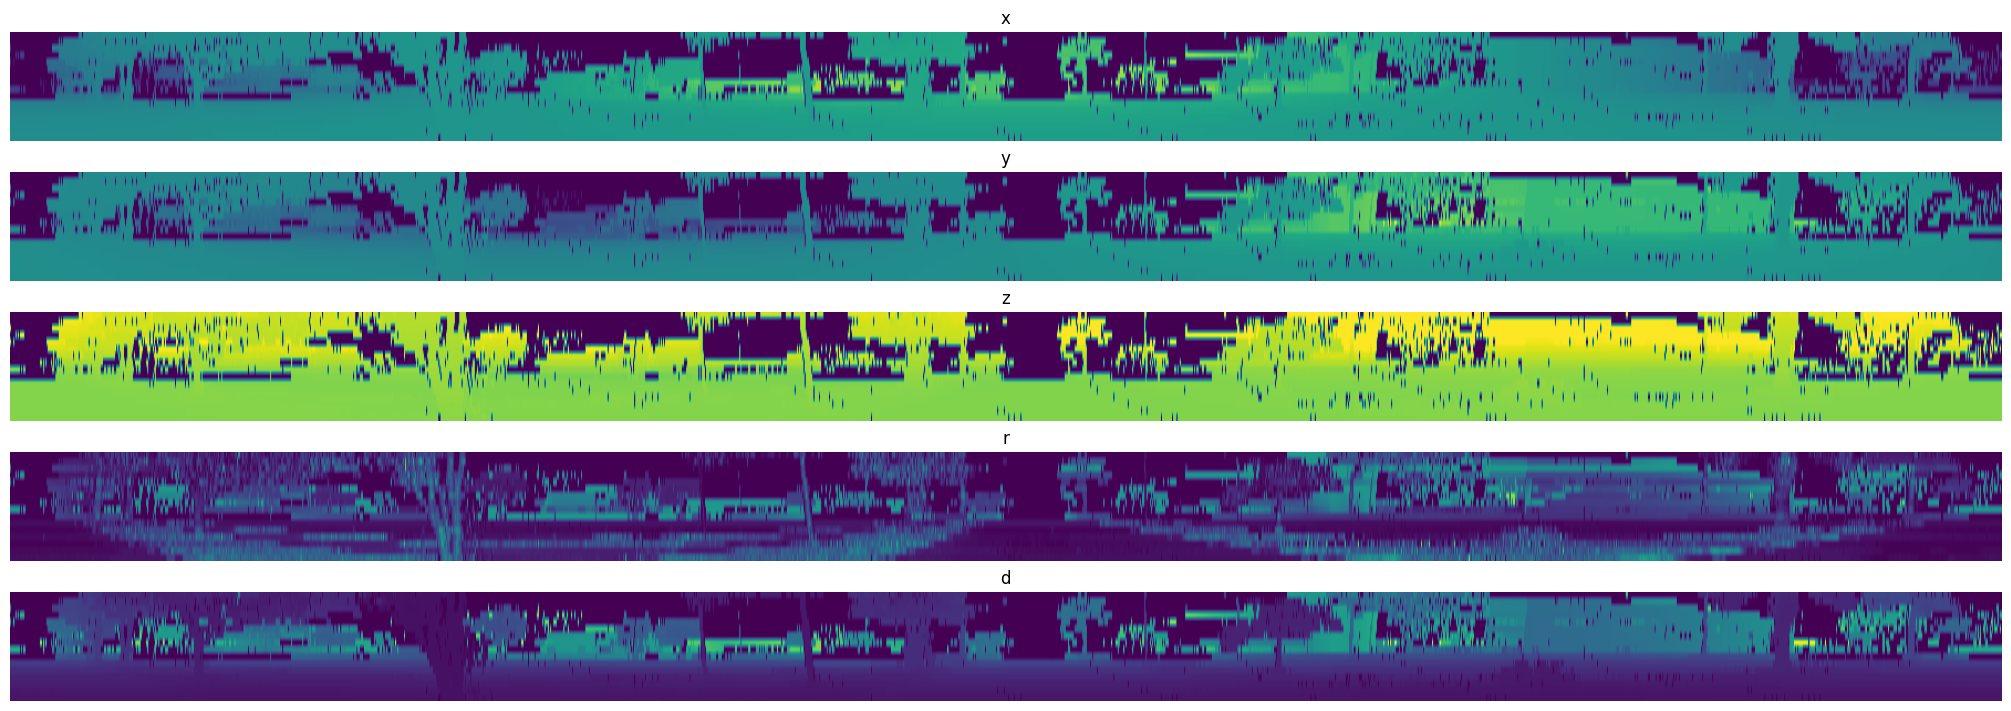

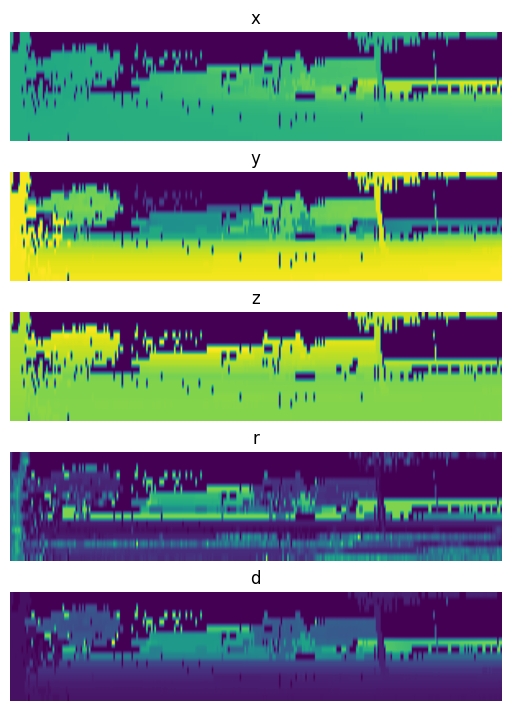

In [248]:
img, _, _ = ds[2158]
plot_projections(img)
plot_slices(img, start=400, end=700)

### GIFS

In [104]:
def plot_projections(img, filename):
    fig, axs = plt.subplots(5, 1, figsize=(20,7), layout='compressed')
    for i, (ax, title) in enumerate(zip(axs, ['x', 'y', 'z', 'r', 'd'])):
        if i < 5:
            ax.imshow(img[:,:,i], aspect="auto")
        ax.set_title(title)
        ax.axis('off')
    plt.savefig(filename)
    plt.close(fig)

start = 2000
end = 2200
for i in range(start, end):
    img, _, _ = ds[i]
    plot_projections(img, filename=f"../../images/frame{i}.png")

In [ ]:
import imageio.v2 as imageio
import os

image_files = sorted(os.listdir("../../images/"))

name = '../../gifs/16x1800_1.gif'

with imageio.get_writer(name, mode='I', fps=7) as writer:
    for filename in image_files:
        if filename == ".ipynb_checkpoints":
            continue
        image = imageio.imread("../../images/"+filename)
        writer.append_data(image)